# Improts and setup

### Setup envirnonment 

In [2]:
%load_ext autoreload
%autoreload 2

### Import necessaary libraries

In [3]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

import imp

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Import custom libraries

In [4]:
import patch_utils
import image_utils

In [39]:
imp.reload(patch_utils)
imp.reload(image_utils)

<module 'image_utils' from '/home/slavchic/Desktop/209AS_winter_2020/python_files/image_utils/__init__.py'>

# Workspace

### Load labels

In [6]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)### Choose an image

### Choose an image

In [65]:
img1_path = './ImageNet/467863966_a01cbd9d90.jpg'
img2_path = './ImageNet/857502810_4313e2fbd4.jpg'
img3_path = './ImageNet/81-yKbVND-L.png'
img4_path = ''
img5_path = './ImageNet/EJxGm89VUAERo8e.jpg'
img6_path = './ImageNet/flowers.jpg'

number_of_images = 3
my_raw_pillow_images = []

for i in range(number_of_images):
    my_raw_pillow_images.append(PIL.Image.open('./ImageNet/cats' + str(i+1) + '.jpg'))
    if not i== 3: my_raw_pillow_images.append(PIL.Image.open('./ImageNet/dogs' + str(i+1) + '.jpg'))
    

# get train images    
train_set = image_utils.preprocessing(my_raw_pillow_images)

# specify the patch size, mean, std
mean = 0
std = 0.2
size = 45

# get patch initializer
patch_init = np.random.normal(mean, std, (size, size, 3))
mask = np.abs(patch_init) < 1
patch_init *= mask
patch_init = patch_init.astype(np.float32)

length_of_training_set = train_set.shape[0]

### Graph setup

In [66]:
# somewhy utils do not automatically reload; so we have to do it manually
imp.reload(patch_utils)

# Allows not to reboot kernel on each initialization
tf.reset_default_graph() 


# ============================================================================= #
# ============================= declare variables ============================= #
# ============================================================================= #



# declare variable for adversarial patch
naive_patch = tf.get_variable(name="patch", initializer=patch_init, dtype=tf.float32)


# declare a placeholder for the image
train_images = tf.placeholder(name="train_images", shape=(length_of_training_set, 300, 300, 3), dtype=tf.float32)

# declare shifts
x_shifts = tf.placeholder(name="x_shifts", shape=(), dtype=tf.int32)
y_shifts = tf.placeholder(name="y_shifts", shape=(), dtype=tf.int32)

# declare learning rate
learning_rate = tf.placeholder(tf.float32, ())

# declare target class
target_class = tf.placeholder(tf.int32, ())    

# declare initializer for variables
patch_initializer = tf.variables_initializer([naive_patch])


# ============================================================================= #
# ========================== preprocessing operations ========================= #
# ============================================================================= #


# multiply patch
patch_array = patch_utils.multiply(naive_patch, train_images)

# shift patch
shifted_patch_array = patch_utils.shift(patch_array, x_shifts, y_shifts)

# apply patch
adv_images = patch_utils.applicator(shifted_patch_array, train_images)



# ============================================================================= #
# =============================== gradient step =============================== #
# ============================================================================= #

# get target vector
labels = tf.one_hot(np.ones((length_of_training_set)) *target_class, 1000)

# declare inception
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
with tf.contrib.framework.arg_scope(arg_scope):
    tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(adv_images,
                                                                        num_classes=1001,   
                                                                        is_training=False,  
                                                                        reuse = False)            
    tf_logits = tf_logits[:,1:]
    probs = tf.nn.softmax(tf_logits) 


# compute losses for each image
losses = tf.nn.softmax_cross_entropy_with_logits(logits=tf_logits, labels=[labels])    

# compute the sum of all losses
sum_loss = tf.math.reduce_sum(losses) / length_of_training_set

# update patch
optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(sum_loss, var_list=[naive_patch])

# ============================================================================= #
# ============================= process the result ============================ #
# ============================================================================= #



# get the result
result = adv_images



# debug function
printer = tf.print(result)



# ============================================================================= #
# =============================== declare savers ============================== #
# ============================================================================= #



# save the patch
patch_saver = tf.train.Saver([naive_patch])

# declare inception variables to restore
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore inception variables
inception_saver = tf.train.Saver(restore_vars)

INFO:tensorflow:Scale of 0 disables regularizer.


### Save current graph

In [45]:
# use this cell if you need to save graph to corresponding folder 
writer = tf.summary.FileWriter('./graphs', tf.get_default_graph())

# Run learning 

In [67]:
num_steps = 40

# specify whether we start to learn new patch or continue from a checkpoint
load_patch = True
# specify whether to save patch
save_patch = True

my_feed_dict = {
    x_shifts: 50,
    y_shifts: 100,
    learning_rate: 5e-1,
    target_class: 200,
    train_images: train_set
}

with tf.Session() as sess:
    # load weights of the model
    inception_saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    if load_patch:
        patch_saver.restore(sess, './patch_weights/45x45/patch45x45')
    else:
        # run the variable initializer operation
        sess.run(patch_initializer)    

    # make gradient updates
    for i in range(num_steps):
        # optim_step is operation, not variable; it updates x_hat 
        _, loss_value = sess.run([optim_step, sum_loss], feed_dict=my_feed_dict)

        # print loss
        if (i+1) % 5 == 0: print('step %d, loss=%g' % (i+1, loss_value))  
    
    # now let's get image with patch their value
    ex_adv_images = sess.run(result, feed_dict=my_feed_dict)
    
    # and probabilities corresponding to it
    ex_adv_probs = sess.run(probs, feed_dict=my_feed_dict)
    
    if save_patch:
        patch_saver.save(sess, './patch_weights/45x45/patch45x45')

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./patch_weights/45x45/patch45x45
step 5, loss=8.35713
step 10, loss=8.34998


KeyboardInterrupt: 

Tibetan terrier, chrysanthemum dog


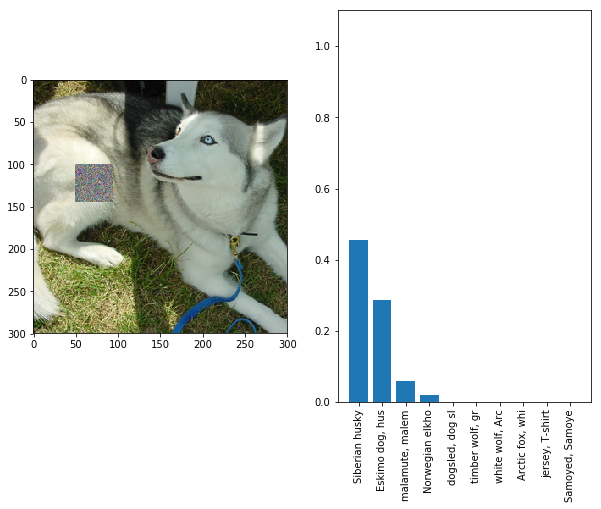

In [64]:
#image_utils.plot_adversarial_image(ex_adv_image.reshape(300, 300, 3))

image_num = 1
print(imagenet_labels[200])
post_proc_adv_images = image_utils.postprocessing(ex_adv_images)
image_utils.show_probs(post_proc_adv_images[image_num], ex_adv_probs[image_num], imagenet_labels, target_class=200)